# Business Understanding
We hebben een dataset gekregen die bestaat uit strafbare feiten van de stad Denver van de afgelopen vijf jaar. De gegevens komen van het National Incident Based Reporting System (NIBRS). 

### User stories
- Als gemeente wil ik zien waar het centrum ligt van de drugshandel, zodat de drugshandel gericht kan worden aangepakt.
    - We willen een clusteranalyse op de wijk waar de meeste drugshandel plaatsvindt. 
    - Doormiddel van de elbow methode wordt er gekeken hoeveel clusters er komen. 
    


# Data Understanding

In [27]:
# importeer je packages
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import matplotlib.pyplot as plt

C:\Users\hteri\Program Files\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## Collect initial data
De data is aan ons aangeleverd in de vorm van twee .csv bestanden. Deze zijn met elkaar gekoppeld aan de hand van de identieke kolomnamen ‘offense_code’. Andere interessante gegevens zijn de datum en plaats waar en wanneer het strafbare feit is gepleegd. Met name de verkeersincidenten zijn in Denver erg hoog, we zullen specifiek voor de verkeersincidenten extra analyses doen.

In [3]:
df_crime = pd.read_csv('crime.csv', parse_dates=[
    'FIRST_OCCURRENCE_DATE',
    'LAST_OCCURRENCE_DATE',
    'REPORTED_DATE'
], dtype={
    'IS_CRIME': 'bool',
    'IS_TRAFFIC': 'bool'
})
df_offense_codes = pd.read_csv('offense_codes.csv')

## Describe data

In [3]:
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454540 entries, 0 to 454539
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   INCIDENT_ID             454540 non-null  int64         
 1   OFFENSE_ID              454540 non-null  int64         
 2   OFFENSE_CODE            454540 non-null  int64         
 3   OFFENSE_CODE_EXTENSION  454540 non-null  int64         
 4   OFFENSE_TYPE_ID         454540 non-null  object        
 5   OFFENSE_CATEGORY_ID     454540 non-null  object        
 6   FIRST_OCCURRENCE_DATE   454540 non-null  datetime64[ns]
 7   LAST_OCCURRENCE_DATE    152118 non-null  datetime64[ns]
 8   REPORTED_DATE           454540 non-null  datetime64[ns]
 9   INCIDENT_ADDRESS        414371 non-null  object        
 10  GEO_X                   450607 non-null  float64       
 11  GEO_Y                   450607 non-null  float64       
 12  GEO_LON                 450606

0. **INCIDENT_ID :** Bestaat uit een combinatie van INCIDENT_ID, OFFENSE_CODE en OFFENSE_CODE_EXTENSION. Dit zorgt ervoor dat iedere overtreding uniek identificeerbaar is.
1. **OFFENSE_ID:** Unieke integer voor iedere melding. Zo kan het bijvoorbeeld voorkomen dat er meerdere overtredingen worden gepleegd per melding
2. **OFFENSE_CODE:** De code waarmee verwezen wordt naar een algemene soort overtreding. In combinatie met
3. **OFFENSE_CODE_EXTENSION:** kan het specifieke misdrijf worden achterhaald.Een uitbreiding op OFFENSE_CODE. Geeft een specifiek misdrijf aan (ander CSV-bestand).
4. **OFFENSE_TYPE_ID:** Geeft de naam van het misdrijf weer. Bijvoorbeeld een aanrijding onder invloed, heroïnegebruik, etc.
5. **OFFENSE_CATEGORY_ID:** Geeft de basisnaam van het misdrijf weer. Een generalisatie van OFFENSE_TYPE_ID. Zo valt het gebruik van zowel heroïne als wiet onder het algemene misdrijf ‘drugsgebruik’.
6. **FIRST_OCCURRENCE_DATE:** De eerst mogelijk datum van het incident.
7. **LAST_OCCURRENCE_DATE:** als de FIRST_OCCURRENCE_DATE en de LAST_OCCURRENCE_DATE kolommen beide zijn ingevulgd dan is er een schatting gemaakt van het incident
8. **REPORTED_DATE:** datum waarop het delict werd gerapporteerd
9. **INCIDENT_ADDRESS:** de straat waar het incident heeft plaats gevonden. Deze kolom is niet altijd ingevuld in verband met privacy.
10. **GEO_X:** Geografische coördinaten
11. **GEO_Y:** GEO_Y
12. **GEO_LON:** lengtegraad
13. **GEO_LAT:** breedtegraad
14. **DISTRICT_ID:** Afgebakend geografisch gebied in Denver.
15. **PRECINCT_ID:** Het id van het gebied waar het incident is afgerond?
16. **NEIGHBORHOOD_ID:** buurt waarin het delict plaatsvond
17. **IS_CRIME:** Was het incident een misdaad?
18. **IS_TRAFFIC:** Was het incident een verkeersincident?

Wat ons opvalt aan kolommen waarin een datum hoort te staat dat ze van het type object zijn. Wij hebben bij het inporteren van het CSV-bestand dan ook het type aangepast naar een date. Daarnaast hebben wij de kolommen van IS_CRIME en IS_TRAFFIC aangepast naar een boolean.

In [4]:
df_crime.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
INCIDENT_ID,454540.0,4.207075e+09,1.457081e+10,2.019600e+04,2.016748e+09,2.018438e+09,2.020122e+09,2.020890e+12
OFFENSE_ID,454540.0,4.207075e+15,1.457081e+16,2.019652e+10,2.016748e+15,2.018438e+15,2.020122e+15,2.020890e+18
OFFENSE_CODE,454540.0,3.715744e+03,1.647371e+03,9.020000e+02,2.305000e+03,2.999000e+03,5.441000e+03,7.399000e+03
OFFENSE_CODE_EXTENSION,454540.0,2.070577e-01,5.784915e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
GEO_X,450607.0,3.165068e+06,7.114081e+05,1.000000e+00,3.138868e+06,3.145749e+06,3.163062e+06,4.067477e+07
GEO_Y,450607.0,1.695826e+06,2.323741e+05,1.000000e+00,1.683238e+06,1.694794e+06,1.701977e+06,1.046707e+08
GEO_LON,450606.0,-1.049235e+02,1.985000e+00,-1.154641e+02,-1.050062e+02,-1.049818e+02,-1.049203e+02,5.000000e-07
GEO_LAT,450606.0,3.971875e+01,7.516972e-01,0.000000e+00,3.970800e+01,3.973981e+01,3.975958e+01,3.990431e+01
DISTRICT_ID,454539.0,3.528043e+00,1.782229e+00,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00,7.000000e+00
PRECINCT_ID,454539.0,3.703956e+02,1.790605e+02,1.110000e+02,2.210000e+02,3.230000e+02,5.210000e+02,7.590000e+02


Wat kunnen afleiden uit de volgende tabel:
- Er zijn **454545** incident meldingen geregisteerd.

In [5]:
print(df_crime.head());

   INCIDENT_ID         OFFENSE_ID  OFFENSE_CODE  OFFENSE_CODE_EXTENSION  \
0   2018869789   2018869789239900          2399                       0   
1    202111218    202111218570700          5707                       0   
2  20176005213  20176005213239901          2399                       1   
3  20196012240  20196012240230800          2308                       0   
4   2018861883   2018861883501600          5016                       0   

                  OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID FIRST_OCCURRENCE_DATE  \
0                     theft-other             larceny   2018-12-27 15:58:00   
1            criminal-trespassing    all-other-crimes   2021-01-06 21:20:00   
2                   theft-bicycle             larceny   2017-06-08 13:15:00   
3                 theft-from-bldg             larceny   2019-12-07 13:07:00   
4  violation-of-restraining-order    all-other-crimes   2018-12-22 20:15:00   

  LAST_OCCURRENCE_DATE       REPORTED_DATE     INCIDENT_ADDRESS      GEO_X

# Data Preparation
## Select Data
Om de job story uit te werken. Hebben wij de volgende kolommen nodig:
- OFFENSE_CATEGORY_ID 
- OFFENSE_TYPE_ID
- NEIGHBORHOOD_ID


# Modeling

In [130]:
# filter op drugs verkoop
sellDrug=df_crime[(df_crime['OFFENSE_CATEGORY_ID']=='drug-alcohol') 
                  & (df_crime['OFFENSE_TYPE_ID'].str.contains("sell")
                    & (df_crime['OFFENSE_TYPE_ID'].str.contains("drug")))]

dfCountSellDrug = sellDrug.groupby('NEIGHBORHOOD_ID')['NEIGHBORHOOD_ID'].agg(Aantal='count').sort_values(by='Aantal', ascending=False)
dfCountSellDrug

,Aantal
NEIGHBORHOOD_ID,
capitol-hill,477
five-points,337
north-capitol-hill,204
east-colfax,157
civic-center,129
...,...
southmoor-park,3
country-club,3
fort-logan,2


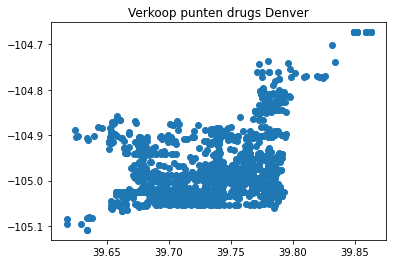

In [131]:
plt.plot()
plt.scatter(x=sellDrug[['GEO_LAT']],y=sellDrug[['GEO_LON']])
plt.title('Verkoop punten drugs Denver')
plt.show()

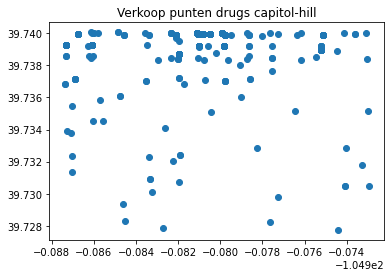

In [140]:
NEIGHBORHOOD = "capitol-hill"
sellDrug=sellDrug[sellDrug['NEIGHBORHOOD_ID'] == NEIGHBORHOOD ]

plt.plot()
plt.scatter(y=sellDrug[['GEO_LAT']],x=sellDrug[['GEO_LON']])
plt.title('Verkoop punten drugs ' + NEIGHBORHOOD )
plt.show()

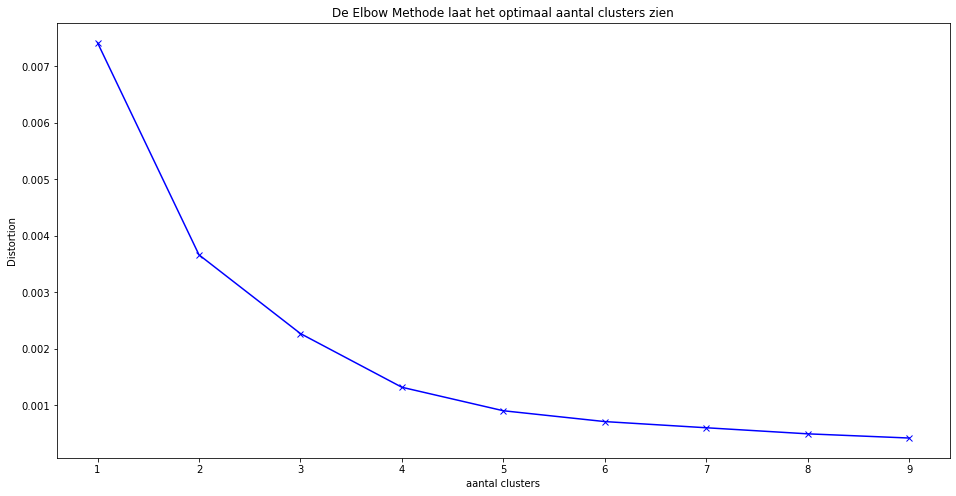

In [133]:
 test = sellDrug[['GEO_LAT','GEO_LON']]

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(test)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('aantal clusters')
plt.ylabel('Distortion')
plt.title('De Elbow Methode laat het optimaal aantal clusters zien')
plt.show()

[39.73879628 39.73947664 39.73092012 39.73874224]
[-104.98673417 -104.98063899 -104.9808681  -104.97528391]


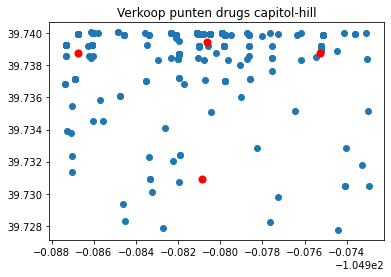

In [139]:
Kmean = KMeans(n_clusters=4)
Kmean.fit(test)

plt.plot()
plt.scatter(y=test[['GEO_LAT']],x=test[['GEO_LON']])
plt.title('Verkoop punten drugs ' + NEIGHBORHOOD )

centers = Kmean.cluster_centers_
plt.scatter(y=centers[:, 0], x=centers[:, 1], c='red', s=50)

print(centers[:,0])
print(centers[:,1])
plt.show()


In [135]:
import os
import folium

map_osm = folium.Map(location=[39.742043,-104.89530725])


# add marker one by one on the map
for i in range(0,len(test)):
   folium.Marker(
      location=[test.iloc[i]['GEO_LAT'], test.iloc[i]['GEO_LON']]
   ).add_to(map_osm)

# add marker one by one on the map
for i in range(0,len(centers)):
   folium.Marker(location=[centers[i, 0], centers[i, 1]],popup="centrum" ,icon=folium.Icon(color="red"),).add_to(map_osm)

# Show the map again
map_osm

# Evaluation

- Uit de bovenstaande spreiding diagram is af te  leiden dat de centra van de drugsverkoop zich op de rode punten bevinden. Ons advies zou dan ook zijn om in deze centra extra (gespecialiseerde) agenten in te zetten. De centra bevinden zich nabij de volgende straten:

!! tip dit is gebaseerd op een wijk als er dus op een rand van een andere wijk ook veel drugsverkoop zou het cluster center moeten veranderen